# InstaBot - Part 2

In [292]:
''' Load WebDriver & libraries '''

from time import sleep
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


service= Service(executable_path="\\chromedriver")
driver = webdriver.Chrome(service=service)
driver

<selenium.webdriver.chrome.webdriver.WebDriver (session="42645159c2ef18c98b956ab48f532f47")>

In [293]:
''' Logging in '''

username = "SAMPLE USERNAME" 
password = "SAMPLE PASSWORD"

def home():
    driver.get('https://www.instagram.com')
    sleep(5)
    
def login(username, password):
    home()
    username_box = driver.find_element(By.NAME, 'username')
    password_box = driver.find_element(By.NAME, 'password')
    username_box.clear
    username_box.send_keys(username)
    password_box.clear
    password_box.send_keys(password)
    password_box.submit()
    
def turn_off_notifications():
    try:
        notifications_popup = driver.find_element(By.CLASS_NAME, '_a9--')
        notifications_popup.click()
    except NoSuchElementException:
        pass

login(username, password)
turn_off_notifications()

### 1 -  Now your friend has followed a lot of different food bloggers, he needs to analyse the habits of these bloggers.

In [301]:
def get_menu_buttons(button_name):
    sleep(3)
    buttons = {
        'Search': driver.find_element("css selector", "svg[aria-label='Search']"),
        'Profile': driver.find_element(By.XPATH, "//div[@class='xh8yej3 x1iyjqo2']//div[8]")
    }
    return buttons[button_name]

def search(word_to_search):
    search_button = get_menu_buttons('Search')
    search_button.click()
    sleep(4)
    search_box = driver.find_element("css selector", "input[aria-label='Search input']")
    search_box.clear()
    search_box.send_keys(word_to_search)
    sleep(4)

def get_search_results_df():
    names_driver = driver.find_elements("xpath", '//div[@role="none"]')
    names_list = []
    for j in names_driver:
        combined_text = j.text
        names = combined_text.split('\n')
        names_list.append(names)
    df = pd.DataFrame(names_list, columns = ['Id','Name'])
    return(df)

def get_count_followers_str():
    element = driver.find_element(By.PARTIAL_LINK_TEXT, 'followers')
    element2 = element.find_element(By.TAG_NAME,'span')
    followers_str = element2.text
    return followers_str

def turn_count_str_to_int(str_value):
    multiply = {
        'K':1000,
        'M':1000000,
        '':1000
    }
    numeric_part = float('.'.join(re.findall(r'\d+', str_value)))
    alpha_part = ''.join(re.findall(r'[a-zA-Z]+', str_value))
    int_value = int(numeric_part * multiply[alpha_part])
    # print(str_value, numeric_part, alpha_part, int_value)
    return(int_value)

def turn_count_list_numeric(str_list):
    followers_count_int = []
    for i in str_list:
        a = turn_count_str_to_int(i)
        followers_count_int.append(a)
    return(followers_count_int)

#### 1.1 From the list of instagram handles you obtained when you searched ‘food’ in previous project. Open the first 10 handles and find the top 5 which have the highest number of followers


In [302]:
''' Get top 10 handles for "food" '''

search('food')
df_profiles = get_search_results_df()
mask = ~df_profiles['Id'].str.startswith('#')
df_profiles = df_profiles[mask]
df_profiles = df_profiles.iloc[0:10, 0]

In [303]:
''' Get followers from top 10 handles '''

url_base = 'https://www.instagram.com/'
followers_count_str = []
for i in df_profiles:
    profile = i
    url = url_base + profile
    driver.get(url)
    sleep(5)
    n = get_count_followers_str()
    followers_count_str.append(n)

In [304]:
''' Cleaning and finding top 5 most followed '''

followers_list = turn_count_list_numeric(followers_count_str)
df_followed = pd.DataFrame({'User':df_profiles, 'Followers':followers_list})
df_followed = df_followed.sort_values('Followers', ascending=False)
df_followed = df_followed.iloc[0:5,]
df_followed

,User,Followers
4,foodporn,1100000
6,food,182000
8,foodandtravelmx,116000
0,foodandpleasure_,101000
3,delhifoodguide,100000


#### 1.2 Now Find the number of posts these handles have done in the previous 3 days.


In [305]:
def get_navigation_buttons():
    ''' function that returns next, back and like buttons as selenium objects, also returns unlike flag '''
    
    button_list = driver.find_elements(By.XPATH, '//button[@class="_abl-"]')
    idx, next_idx = 0, 0
    for i in button_list:
        try:
            element = i.find_element(By.TAG_NAME, 'title')
            txt = element.get_attribute("innerHTML")
            if (txt == 'Next'):
                next_idx = idx
        except:
            pass
        idx+=1
    return(button_list[next_idx])

def open_first_posts():
    first_element = driver.find_element(By.XPATH, '//div[@class="_aagw"]')
    first_element.click()
    sleep(3)

def get_post_date():
    # open_posts()
    element = driver.find_element(By.TAG_NAME,'time')
    element.get_attribute("outerHTML")
    fecha_str = element.get_attribute("title")
    post_date = datetime.strptime(fecha_str, "%b %d, %Y")
    return(post_date)

def is_3_days():
    today = datetime.now()
    post_date = get_post_date()
    days = (today.date() - post_date.date()).days
    # print(days)
    return (days <= 3)

def next_post():
    sleep(3)
    next_button = get_navigation_buttons()
    next_button.click()

def get_count_posts():
    post_count = 0
    open_first_posts()
    # This prevent pinned post
    post_count += 1 if is_3_days() else 0
    next_post()
    # Start at 2nd post
    while(is_3_days()):
        post_count += 1
        next_post()
    return post_count

In [306]:
url_base = 'https://www.instagram.com/'

df_profiles = df.iloc[0:5,0]

followers_count_post = []
for i in df_profiles:
    profile = i
    url = url_base + profile
    driver.get(url)
    sleep(5)
    n = get_count_posts()
    followers_count_post.append(n)

In [307]:
df_recent_posts = pd.DataFrame({'User':df_profiles, 'Recent Posts':followers_count_post})
df_recent_posts

,User,Recent Posts
8,foodporn,0
0,foodtalkindia,3
6,food,1
1,foodandpleasure_,1
3,delhifoodguide,0


#### 1.3 Depict this information using a suitable graph.


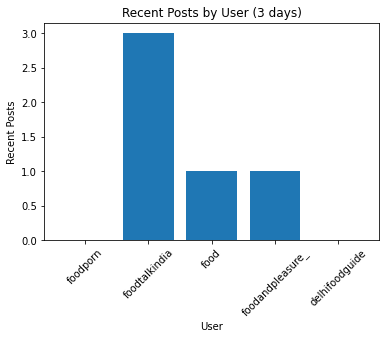

In [308]:
import matplotlib.pyplot as plt

plt.bar(df_recent_posts['User'], df_recent_posts['Recent Posts'])
plt.xlabel('User')
plt.ylabel('Recent Posts')
plt.title('Recent Posts by User (3 days)')

plt.xticks(rotation=45)
plt.show()


### 2 - Your friend also needs a list of hashtags that he should use in his posts.

In [309]:
def get_words():
    element = driver.find_element(By.XPATH,'//div[@class = "_a9zs"]')
    # element_1 = element.find_element(By.TAG_NAME, 'a')
    element2 = element.find_element(By.TAG_NAME, 'h1')
    # element_1.get_attribute("outerHTML")
    words_list = [i for i in element2.text.split()]
    return words_list

def get_words_10_posts(words_list):
    for posts in range(10):
        post_words = get_words()
        for i in post_words:
            words_list.append(i)
        next_post()
        sleep(3)

def get_hashtags():
    element = driver.find_element(By.XPATH,'//div[@class = "_a9zs"]')
    # element_1 = element.find_element(By.TAG_NAME, 'a')
    element2 = element.find_element(By.TAG_NAME, 'h1')
    # element_1.get_attribute("outerHTML")
    hastags_list = [i for i in element2.text.split() if i.startswith('#')]
    return hastags_list

def get_hashtags_10_posts(hashtags_list):
    for posts in range(10):
        post_hashtags = get_hashtags()
        for i in post_hashtags:
            hashtags_list.append(i)
        next_post()
        sleep(3)

#### 2.1 - Open the 5 handles you obtained in the last question, and scrape the content of the first 10 posts of each handle.


In [310]:
df_profiles = df.iloc[0:5,0]
words_list = []

url_base = 'https://www.instagram.com/'
for i in df_profiles:
    profile = i
    url = url_base + profile
    driver.get(url)
    sleep(3)
    open_first_posts()
    get_words_10_posts(words_list)

#### 2.2 - Prepare a list of all words used in all the scraped posts and calculate the frequency of each word.

In [311]:
words_list = [i.title() for i in words_list] 

words_dict = {}
for i in words_list:
    if i not in words_dict:
        words_dict[i] = 0
    words_dict[i] += 1

In [312]:
df_words = pd.DataFrame(words_dict.items(), columns=['Word','Frequency'])
df_words = df_words.sort_values('Frequency', ascending=False)
df_words

,Word,Frequency
47,The,83
5,A,62
132,And,56
18,To,51
10,In,45
...,...,...
590,#Cafes,1
589,#Brunch,1
588,#Mothersday,1
587,Spots!👯‍♀️,1


#### 2.3 - Create a csv file with two columns : the word and its frequency

In [313]:
df_words.to_csv("Words.csv")

#### 2.4 - Now, find the hashtags that were most popular among these bloggers

In [314]:
hashtags_popular = df_words[df_words['Word'].str.startswith("#")]
hashtags_popular.head(10)

,Word,Frequency
24,#Food,13
248,#Foodblogger,11
249,#Delicious,10
246,#Foodtalkindia,10
247,#Foodiesofindia,10
252,#Discover,10
251,#Instafood,10
250,#Yummy,10
398,#Delhi,5
23,#Foodporn,5


#### 2.5 - Plot a Pie Chart of the top 5 hashtags obtained and the number of times they were used by these bloggers in the scraped posts.

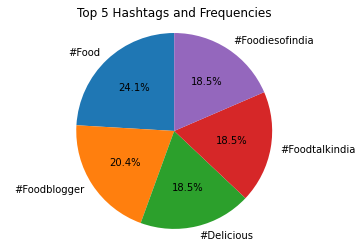

In [326]:
plt.pie(hashtags_popular.head(5)['Frequency'], labels=hashtags_popular.head(5)['Word'], autopct='%1.1f%%', startangle=90)
plt.axis('equal') 
plt.title('Top 5 Hashtags and Frequencies')
plt.show()


### 3 - You need to also calculate average followers : likes ratio for the obtained handles.

#### 3.1 - Find out the likes of the top 10 posts of the 5 handles obtained earlier.

In [315]:
element = driver.find_element(By.XPATH,'//section[@class="_ae5m _ae5n _ae5o"]')

In [232]:
def get_likes():
    element = driver.find_element(By.XPATH,'//section[@class="_ae5m _ae5n _ae5o"]')
    element1 = element.find_elements(By.TAG_NAME, 'span')
    likes_text = element1[-1].text
    try:
        likes_int = int(likes_text.replace(",", ""))
    except ValueError:
        likes_int = 1
    # print(likes_int)
    return likes_int

def get_likes_10_posts():
    sleep(3)
    likes_list = []
    for posts in range(10):
        post_likes = get_likes()
        likes_list.append(post_likes)
        next_post()
        sleep(4)
    return likes_list


In [329]:
likes_list = []

url_base = 'https://www.instagram.com/'
df_profiles = df.iloc[0:5,0]
for i in df_profiles:
    url = url_base + i
    driver.get(url)
    sleep(5)
    open_first_posts()
    likes_list.append(get_likes_10_posts())

In [330]:
likes_dict = {}
for i, j in zip(df_profiles,likes_list):
    likes_dict[i] = j

likes_dict

{'foodporn': [1496, 12334, 165254, 474, 4678, 7676, 3393, 3289, 4985, 1073],
 'foodtalkindia': [241, 668, 123, 532, 256, 377, 124, 561, 363, 545],
 'food': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'foodandpleasure_': [476, 1259, 289, 332, 401, 1255, 103, 839, 260, 925],
 'delhifoodguide': [258, 443, 795, 1029, 155, 505, 336, 304, 248, 1998]}

#### 3.2 - Calculate the average likes for a handle.

In [331]:
for key, values in likes_dict.items():
    avg = sum(values)/len(values)
    likes_dict[key] = avg

df_likes = pd.DataFrame(likes_dict.items(), columns = ['Users', 'Average Likes'])
df_likes

,Users,Average Likes
0,foodporn,20465.2
1,foodtalkindia,379.0
2,food,1.0
3,foodandpleasure_,613.9
4,delhifoodguide,607.1


#### 3.3 - Divide the average likes obtained from the number of followers of the handle to get the average followers:like ratio of each handle.

In [332]:
r = df_likes['Average Likes'].reset_index(drop=True)  / df_followed['Followers'].reset_index(drop=True) 
r

0    0.018605
1    0.002082
2    0.000009
3    0.006078
4    0.006071
dtype: float64

#### 3.4 - Create a bar graph to depict the above obtained information.

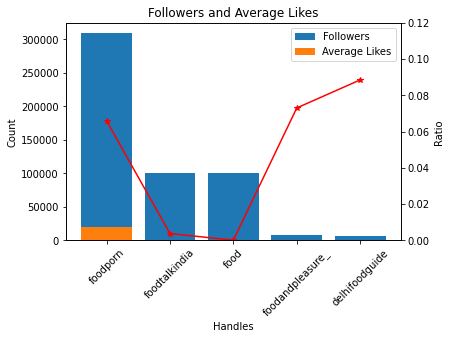

In [291]:
fig, ax1 = plt.subplots()
ax1.bar(df_followed['User'], df_followed['Followers'], label='Followers')
ax1.bar(df_likes['Users'], df_likes['Average Likes'], label='Average Likes')
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_likes['Users'], ratio, marker='*', color='red')
ax2.set_ylabel('Ratio')
ax2.set_ylim(0, 0.12)  

ax1.set_xlabel('Handles')
ax1.set_ylabel('Count')
ax1.set_title('Followers and Average Likes')
ax1.legend()

plt.show()
